<font  style="font-size: 4rem; color: darkviolet"> Image Segmentation with U-Net </font>

AA - 2022/23 - TP9 

*This assignement is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you'll learn about U-Net, a type of CNN designed for fast and precise image segmentation. Specifically, you'll use it to **predict a label for every pixel** in a self-driving car dataset image, a task known as **semantic image segmentation**.

Unlike object detection, which uses bounding boxes to identify objects (including pixels that don't belong to the object), semantic image segmentation allows you to **label each pixel with its corresponding class**, resulting in a precise mask for each object in the image. This is crucial for self-driving cars, which need to accurately identify and understand their surroundings to avoid obstacles and keep people safe.

<img src="data/images_TP9/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

Your objectives for this assignment are to:

* Code a U-Net from scratch
* Understand the difference between a regular CNN and a U-Net
* Use semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical cross-entropy for pixel-wise prediction

###  <font color='darkviolet'> Table of Content

- [1 - The Dataset](#1)
- [2 - U-Net](#2)
    - [2.1 - Model Details](#2-1)
    - [2.2 - Encoder (Downsampling Block)](#2.2)
        - [Exercise - conv_block](#ex-2.2.1)
    - [2.3 - Decoder (Upsampling Block)](#2.3)
        - [Exercise - upsampling_block](#ex-2.3.1)
    - [2.4 - Build the Model](#2.4)
        - [Exercise - unet_model](#ex-2.4.1)
    - [2.5 - Loss Function](#2.5)
    - [2.7 - Dataset Handling](#2.7)
- [3 - Train the Model](#3)
    - [3.1 - Create Predicted Masks](#3.1)
- [4 - Conclusion](#4)

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from data.test_utils import summary, comparator

<a name='1'></a>
## <font color='darkviolet'> 1 - The Dataset

The dataset has subdirectories `CameraRGB` and `CameraMask` containing images and corresponding segmentation masks, respectively.

In [2]:
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list] # the file paths for all the images in the dataset
mask_list = [mask_path+i for i in mask_list]

Check out some of the images and corresponding segmentation masks:

Text(0.5, 1.0, 'Segmentation')

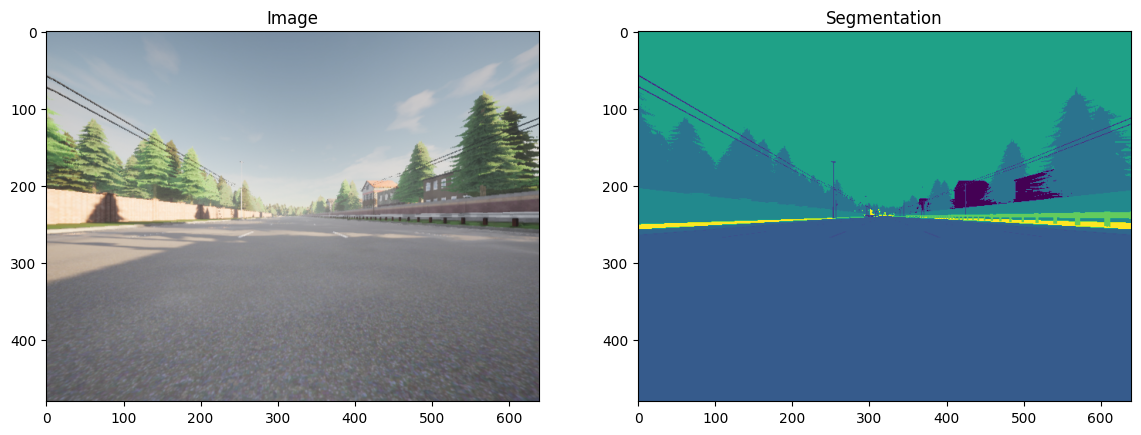

In [3]:
N=119
# Load the image and mask
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

# Plot the original image and its corresponding mask side by side
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

Revise how to create and process a dataset in TensorFlow: https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [4]:
# Create TensorFlow constants for the image and mask file paths
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# Create a TensorFlow dataset from the image and mask constants
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames)) 

In [5]:
# Define a function to process image and mask file paths into preprocessed images
def process_path(image_path, mask_path):
    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode the image to a 3-channel tensor
    img = tf.image.decode_png(img, channels=3)
    # Convert the pixel values to the float32 data type
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    # Reduce the mask to a tensor with shape (height, width, 1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    
    return img, mask

def preprocess(image, mask):
    # Resize to the desired dimensions
    input_image = tf.image.resize(image, (96, 128), method='bilinear')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    
    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

#### <font color='blue'> Q1.1 Describe your dataset. </font>

> The dataset is composed of two folders: CameraRGB and CameraMask. The first one contains standards images from CARLA and the second one the corresponding segmentation masks. 
> The images are RGB images of size 800x600. The segmentation masks are grayscale images of size 800x600. The images and the masks have the same name.

<a name='2'></a>
## <font color='darkviolet'> 2 - U-Net 

U-Net is a deep learning architecture that was originally designed for detecting tumors in medical images. It gets its name from its distinctive U-shaped design, which enables it to perform accurate image segmentation tasks.

At its core, U-Net is a type of Fully Convolutional Network (FCN) that replaces the dense layers of a typical CNN with transposed convolutional layers for upsampling or increasing the resolution of feature maps.

U-Net uses a matching number of convolutions to downsample the input image to a feature map, and transposed convolutions to upsample those maps back up to the original input image size. Additionally, it incorporates **skip connections** between corresponding layers in the encoder and decoder networks, allowing the network to retain fine information that would otherwise be lost during encoding. 
    
<a name='2-1'></a>
### <font color='darkviolet'> 2.1 - Model Details

<img src="data/images_TP9/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. Cropping removes extra pixels from the feature maps in the contracting path to ensure that the spatial dimensions match those of the expanding path.

**Final Feature Mapping Block**: 
In the final layer, a 1x1 convolutional is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used in that layer, and by using a 1x1 convolution, we can transform that dimension by choosing an appropriate number of 1x1 filters. Using an appropriate number of filters allows us to obtain a new set of feature maps with a reduced number of channels, which can be interpreted as having one layer per class. By reducing the number of channels to one layer per class, we can obtain a probability distribution over the classes for each pixel in the input image, which can be used for image segmentation.

**Note**: The figure shows the original U-Net architecture. However, due to computational constraints, you will code a smaller version with half the number of filters. The important thing to remember is that the number of filters is doubled at each step of the architecture.

<a name='2.2'></a>
## <font color='darkviolet'> 2.2 - Encoder (Downsampling Block) 

<!-- <img src="data/images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption> -->

The encoder is a stack of conv_blocks:

Each `conv_block()` is composed of two **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: that will go into the next block. 
- `skip_connection`: that will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer (Conv2D or Dropout, depending on the case). Else, both results will be identical.  

<a name='ex-2.2.1'></a>
### <font color='blue'> Exercise 2.2.1 - conv_block

Implement `conv_block(...)`. Here are the instructions for each step in the `conv_block`, or contracting block: 

* Add two **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [6]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection -- Next layer and skip connection outputs

    """

    # Convolutional layers
    #TODO replace None
    conv = Conv2D(None, # Number of filters
                  None, # Kernek size
                  activation=None,
                  padding=None,
                  kernel_initializer=None)(inputs)
    conv = Conv2D(None,
                  kernel_size=None,
                  activation=None,
                  padding=None,
                  kernel_initializer=None)(conv)
    
    # Optional dropout layer
    if dropout_prob > 0.0:
        #TODO replace None
        conv = None
        
    # Optional max pooling layer
    if max_pooling:
        #TODO replace None
        next_layer = None
    else:
        next_layer = conv
        
    # Output skip connection
    skip_connection = conv
    
    return next_layer, skip_connection

In [7]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2), (2, 2), 'valid']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2),  (2, 2), 'valid']]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

ValueError: The `kernel_size` argument must be a tuple of 2 integers. Received: None

<a name='2.3'></a>
## <font color='darkviolet'> 2.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<!-- <img src="data/images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption> -->

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2.3.1'></a>
### <font color='blue'> Exercise 2.3.1 - upsampling_block

Implement `upsampling_block(...)`.
    
The function takes the arguments `expansive_input` (the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer). The number of filters is the same as in the downsampling block.

A Conv2DTranspose layer is applied to `expansive_input` with n_filters, a shape of (3,3), a stride of (2,2), and padding set to `same`. The output from this layer is concatenated to `contractive_input` to create skip connections.

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """    
    
    # Upsample the expansive input using a transposed convolution
    #TODO replace None
    up = Conv2DTranspose(None, # Number of filters
                 None, # Kernek size
                 strides=None,            # Double the spatial dimensions
                 padding=None)(expansive_input)
    
    # Merge the upsampled output and the contractive input
    merge = concatenate([up, contractive_input], axis=3)
    
    # Apply two 3x3 convolutions with ReLU activation, "same" padding and He normal initialization
    #TODO replace None
    conv = Conv2D(None, # Number of filters 
                 None, # Kernek size
                 activation=None,
                 padding=None,
                 kernel_initializer=None)(merge)
    conv = Conv2D(None,  # Number of filters 
                 None,   # Kernel size
                 activation=None,
                 padding=None,
                 kernel_initializer=None)(conv)
       
    return conv

In [ ]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

<a name='2.4'></a>
## <font color='darkviolet'> 2.4 - Build the Model

You will combine the **encoder** and **decoder** to complete the architecture. You need to specify the number of output channels, which is 23 in this case. This is because there are 23 different labels for each pixel in the self-driving car dataset.

<a name='ex-2.4.1'></a>
### <font color='blue'> Exercise 2.4.1 - unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes as inputs the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer
* Chain the output of the previous block as expansive_input and the corresponding contractive block output
* Note that you must use the second element of the contractive block before the max pooling layer 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and `same` padding. The output of `conv10` is the output of your model. 

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    #=== Contracting Path (encoding)
    #TODO replace None
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(None, None)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(None, None)
    cblock3 = conv_block(None, None)
    cblock4 = conv_block(None, None, dropout_prob=None) # Include a dropout_prob of 0.3 for this layer
    
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(None, None, dropout_prob=None, max_pooling=None) 
    
    #=== Expanding Path (decoding)
    #TODO replace None
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(None, None, None)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(None, None, None)
    ublock8 = upsampling_block(None, None, None)
    ublock9 = upsampling_block(None, None, None)
    
    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)
    
    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(None, None, padding=None)(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
import data.outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), data.outputs.unet_model_output)

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

<a name='2.5'></a>
## <font color='darkviolet'> 2.5 - Loss Function

In semantic segmentation, you have one mask per object class, where each pixel in the mask has a probability that it belongs to a certain class. The highest probability indicates the correct class. 

Use **sparse categorical crossentropy** as the loss function for pixel-wise multiclass prediction, which is more efficient than other loss functions for many classes https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy.

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Define a function that allows you to display both an input image, and its ground truth, i.e., the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

<a name='3'></a>
## <font color='darkviolet'> 3 - Train the Model

In [ ]:
EPOCHS = 5
# VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

#### <font color='blue'> Q3.1 Describe your results.

<a name='3-1'></a>
### <font color='darkviolet'> 3.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(train_dataset, 6)

<a name='4'></a>
### <font color='darkviolet'> 4 - Conclusion

#### <font color='blue'> Q4.1 What is semantic image segmentation?
#### <font color='blue'> Q4.2 How does U-Net perform downsampling and upsampling?
#### <font color='blue'> Q4.3 What are skip connections and why are they used in U-Net?